<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# General:
import pandas as pd
import numpy as np
import os
import csv
import subprocess
import time
import shutil
import glob
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns
import statistics
import pickle
import seaborn as sns

# SciKit-Optimise:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

# SVM:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# RDKit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolfiles, rdMolDescriptors
from rdkit.Chem import SDMolSupplier, Descriptors, Crippen, Lipinski, Fragments
from rdkit import DataStructs

# Misc.:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from scipy import stats
import statistics
import pickle
from mordred import Calculator, descriptors

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
absolute_dGoffset_path = './absolute_dGoffset/'

# dataset_path = '~/Dropbox/FreeSolv/dGlearn-FreeSolv-master/datasets/train_compiled/dGhydr_train.csv'
offset_col_name = 'dGoffset (kcal/mol)'

# set data processing configurations:
PCA_threshold = 0.95  # Keeps n dimensions for x variance explained
replicates = 30  # Number of replicates per subject model
n_calls = 40  # Number of Bayesian optimisation loops for hyperparameter optimisation, 40 is best for convergence, > 60 scales to very expensive
startpoint_BO = np.inf  # Point to consider top-performing model from (MAE/MAD); 1.0 = no improvement on test-set variance
ensemble_size = 10  # Amount of top-scoring models to retain per fold-dataset combination
# KFold parameters:
n_splits = 5  # Number of K-fold splits
random_state = 2  # Random number seed

split = 'dG(hydr)'
translated_subject = 'absolute'

In [10]:
train_df_save_loc = absolute_dGoffset_path + 'train_data.csv'
train_df = pd.read_csv(train_df_save_loc, index_col='Unnamed: 0')
train_dr = absolute_dGoffset_path + 'train_dr/'

test_df_save_loc = absolute_dGoffset_path + 'test_data.csv'
test_dr = absolute_dGoffset_path + 'test_dr/'
test_df = pd.read_csv(test_df_save_loc)

test_df_index_save_loc = absolute_dGoffset_path + 'test_data_index.csv'
test_df_ID = pd.read_csv(test_df_index_save_loc, index_col='Unnamed: 0')
test_ID = test_df_ID.index.tolist()

worst_best_df = pd.read_csv(absolute_dGoffset_path + 'worst_best_ligands.csv', index_col='ID')
worst_best_ID = worst_best_df.index.tolist()

worst_best_MAE = worst_best_df.iloc[:, 4].tolist()

[0.15, 0.29, 5.52, 5.8]

In [4]:
def split_dataset(dataset, n_splits, random_state):
    """KFold implementation for pandas DataFrame.
    (https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold)"""
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    kfolds = []
    global offset_col_name
    
    for train, validate in kf.split(dataset):

        training = dataset.iloc[train]
        train_labels = training[offset_col_name]
        train_set = training.drop(offset_col_name, axis=1)

        validating = dataset.iloc[validate]
        validate_labels = validating[offset_col_name]
        validate_set = validating.drop(offset_col_name, axis=1)

        kfolds.append(
        [[train_set, validate_set],
        [train_labels, validate_labels]]
        )
    
    return kfolds


kfolds = split_dataset(train_df, n_splits, random_state)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
# data = [1.5]*7 + [2.5]*2 + [3.5]*8 + [4.5]*3 + [5.5]*1 + [6.5]*8
# density = gaussian_kde(data)
# xs = np.linspace(0,8,200)
# density.covariance_factor = lambda : .25
# density._compute_covariance()
# plt.plot(xs,density(xs))
# plt.show()

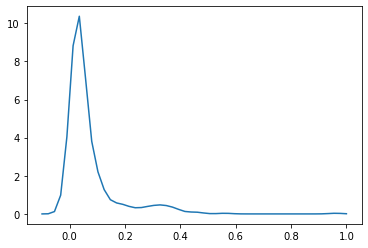

OSError: File error: Bad input file ./absolute_dGoffset/train_dr/mobley_5371840.sdf

In [7]:
# fold_num = list(range(1, n_splits + 1))
for mol in worst_best_ID:

    trgt_suppl = Chem.SDMolSupplier(test_dr + str(mol) + '.sdf')
    trgt_fp = Chem.RDKFingerprint(trgt_suppl[0])

    ID = mol

    fold_num = 1
    for fold in kfolds:
        train_IDs = fold[0][0].index.tolist()
        validate_IDs = fold[0][1].index.tolist()

        # retrieve SDFs
        train_suppl = [Chem.SDMolSupplier(train_dr + str(sdf) + '.sdf')
                       for sdf in train_IDs]

        valdtn_suppl = [Chem.SDMolSupplier(train_dr + str(sdf) + '.sdf')
                        for sdf in validate_IDs]

        # generate fingerprints
        train_fp = [Chem.RDKFingerprint(mol[0]) for mol in train_suppl]
        valdtn_fp = [Chem.RDKFingerprint(mol[0]) for mol in valdtn_suppl]

        # compute similarities
        train_similarity = [DataStructs.FingerprintSimilarity(trgt_fp, train_mol)
                            for train_mol in train_fp]

        valdnt_similarity = [DataStructs.FingerprintSimilarity(trgt_fp, valdnt_mol)
                            for valdnt_mol in valdtn_fp]

        # plt.rcParams.update({'figure.max_open_warning': 0})
        # plt.figure()

        # density plot
        density = gaussian_kde(train_similarity)
        xs = np.linspace(-0.1, 1.0)
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        plt.plot(xs,density(xs))
        plt.show()

#         title = ID + '_fold ' + str(fold_num)

#         # plt.title(title)
#         # ax.set_title(title)
#         # plt.xlabel('Fingerprint similarity')
#         # plt.ylabel('Frequency')
#         # plt.legend()
#         # plt.show()
#         save_loc = absolute_dGoffset_path + ID + '_fold_' + str(fold_num) + '_fp_hist.png'
#         plt.savefig(save_loc)

#         fold_num += 1
        
    break

In [ ]:
# # fold_num = list(range(1, n_splits + 1))
# for mol in worst_best_ID:

#     trgt_suppl = Chem.SDMolSupplier(test_dr + str(mol) + '.sdf')
#     trgt_fp = Chem.RDKFingerprint(trgt_suppl[0])

#     ID = mol

#     fig, axs = plt.subplots(1, 5, figsize=(15, 6), facecolor='w', edgecolor='k')
# #     fig, axs = plt.subplots()
#     print(axs)
#     print(type(axs))
#     fig.subplots_adjust(hspace=.5, wspace=.001)

#     fold_num = 1
# #     for ax, fold in zip(axs.ravel(), kfolds):
#     for ax, fold in zip(axs, kfolds):
#         train_IDs = fold[0][0].index.tolist()
#         validate_IDs = fold[0][1].index.tolist()

#         # retrieve SDFs
#         train_suppl = [Chem.SDMolSupplier(train_dr + str(sdf) + '.sdf')
#                        for sdf in train_IDs]

#         valdtn_suppl = [Chem.SDMolSupplier(train_dr + str(sdf) + '.sdf')
#                         for sdf in validate_IDs]

#         # generate fingerprints
#         train_fp = [Chem.RDKFingerprint(mol[0]) for mol in train_suppl]
#         valdtn_fp = [Chem.RDKFingerprint(mol[0]) for mol in valdtn_suppl]

#         # compute similarities
#         train_similarity = [DataStructs.FingerprintSimilarity(trgt_fp, train_mol)
#                             for train_mol in train_fp]

#         valdnt_similarity = [DataStructs.FingerprintSimilarity(trgt_fp, valdnt_mol)
#                             for valdnt_mol in valdtn_fp]

#         # plt.rcParams.update({'figure.max_open_warning': 0})
#         # plt.figure()

#         # density plot
#         sns.distplot(train_similarity,
#                      hist=False,
#                      kde=True,
#                      kde_kws={'linewidth': 3},
#                      label='Train similarity')

#         sns.distplot(valdnt_similarity,
#                      hist=False,
#                      kde=True,
#                      kde_kws={'linewidth': 3},
#                      label='Validation similarity')

#         title = ID + '_fold ' + str(fold_num)

#         # plt.title(title)
#         # ax.set_title(title)
#         # plt.xlabel('Fingerprint similarity')
#         # plt.ylabel('Frequency')
#         # plt.legend()
#         # plt.show()
#         save_loc = absolute_dGoffset_path + ID + '_fold_' + str(fold_num) + '_fp_hist.png'
#         plt.savefig(save_loc)

#         fold_num += 1
        
#     break

In [ ]:
# help(plt.subplots)

In [ ]:
# for mol in worst_best_ID:
    
#     trgt_suppl = Chem.SDMolSupplier(test_dr + str(mol) + '.sdf')
#     trgt_fp = Chem.RDKFingerprint(trgt_suppl[0])
    
#     for fold in kfolds:
#         train_IDs = fold[0][0].index.tolist()
#         validate_IDs = fold[0][1].index.tolist()
        
#         # retrieve SDFs
#         train_suppl = [Chem.SDMolSupplier(train_dr + str(sdf) + '.sdf') 
#                        for sdf in train_IDs]

#         valdtn_suppl = [Chem.SDMolSupplier(train_dr + str(sdf) + '.sdf') 
#                         for sdf in validate_IDs]
        
#         # generate fingerprints
#         train_fp = [Chem.RDKFingerprint(mol[0]) for mol in train_suppl]
#         valdtn_fp = [Chem.RDKFingerprint(mol[0]) for mol in valdtn_suppl]
        
#         # compute similarities
#         train_similarity = [DataStructs.FingerprintSimilarity(trgt_fp, train_mol)
#                         for train_mol in train_fp]
        
#         break

In [ ]:
# fold_num = 1
# for fold in kfolds:
#     train_IDs = fold[0][0].index.tolist()
#     validate_IDs = fold[0][1].index.tolist()
#     test_IDs = test_ID
#     wb_IDs = worst_best_ID

#     # retrieve SDFs
#     train_suppl = [Chem.SDMolSupplier(train_dr + str(sdf) + '.sdf') 
#                    for sdf in train_IDs]

#     valdtn_suppl = [Chem.SDMolSupplier(train_dr + str(sdf) + '.sdf') 
#                for sdf in validate_IDs]

#     test_suppl = [Chem.SDMolSupplier(test_dr + sdf + '.sdf') 
#            for sdf in test_ID]
    
#     wb_suppl = [Chem.SDMolSupplier(test_dr + sdf + '.sdf')
#                   for sdf in wb_IDs]

#     # generate fingerprints
#     train_fp = [Chem.RDKFingerprint(mol[0]) for mol in train_suppl]
#     valdtn_fp = [Chem.RDKFingerprint(mol[0]) for mol in valdtn_suppl]
#     test_fp = [Chem.RDKFingerprint(mol[0]) for mol in test_suppl]
#     wb_fp = [Chem.RDKFingerprint(mol[0]) for mol in wb_suppl]

#     # compare fingerprints
#     test_train_similarity = [DataStructs.FingerprintSimilarity(test_mol, train_mol)
#                             for test_mol in test_fp
#                             for train_mol in train_fp]

#     test_valdtn_similarity = [DataStructs.FingerprintSimilarity(test_mol, valdtn_mol)
#                         for test_mol in test_fp
#                         for valdtn_mol in valdtn_fp]
    
#     train_wb_similarity = [DataStructs.FingerprintSimilarity(test_mol, train_mol)
#                              for test_mol in wb_fp
#                              for train_mol in train_fp]

#     valdtn_wb_similarity = [DataStructs.FingerprintSimilarity(test_mol, valdtn_mol)
#                               for test_mol in wb_fp
#                               for valdtn_mol in valdtn_fp]

#     # density plot
#     sns.distplot(train_wb_similarity,
#                  hist = False,
#                  kde = True,
#                  kde_kws = {'linewidth': 3},
#                  label = 'wb vs train')

#     sns.distplot(valdtn_wb_similarity,
#                  hist = False,
#                  kde = True,
#                  kde_kws = {'linewidth': 3},
#                  label = 'wb vs valdtn')
    
# #     plt.hist(test_train_similarity, 
# #              histtype='step', 
# #              bins=list(np.linspace(0, 1, 100, endpoint=False)), 
# #              label='train vs test')

# #     plt.hist(test_valdtn_similarity, 
# #              histtype='step', 
# #              bins=list(np.linspace(0, 1, 100, endpoint=False)), 
# #              label='valdtn vs test')

#     title = 'Fold ' +  str(fold_num)
    
#     plt.title(title)
#     plt.xlabel('Fingerprint similarity')
#     plt.ylabel('Frequency')
#     plt.legend()
    
#     fold_num += 1